# Import Packages

In [1]:
import pandas as pd
import numpy as np
import random
from plotnine import *

# repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# datetime 
from datetime import timedelta, date, datetime
from dateutil.relativedelta import relativedelta

# Preliminary data analysis

Load the datasets we exported earlier.

In [2]:
# import the datasets from pickle files
demographics_problems_merged = pd.read_pickle('../output/demographics_problems_merged.pkl')
living_situation_change = pd.read_pickle('../output/living_situation_change.pkl')
in_patient_admissions = pd.read_pickle('../output/in_patient_admissions.pkl')
emergency_crisis_services = pd.read_pickle('../output/emergency_crisis_services.pkl')
presenting_problems = pd.read_pickle('../output/presenting_problems.pkl')

The initial classifier seems to have way more data for the pre-covid data. So for a reasonable comparison, we will subset the data frame to an equal number of month pre and post covid start date.

In [3]:
# Create the lower and upper bound of the dataset

date_cutoff = pd.to_datetime("2020-03-01")

def compare_disparities(df: pd.DataFrame, month_bandwidth: int):
    pre_change_lower_bound = date_cutoff - relativedelta(months = month_bandwidth)
    post_change_upper_bound = date_cutoff + relativedelta(months = month_bandwidth)
    print(f"Pre Change Lower Bound: {pre_change_lower_bound}, Post Change Upper Bound: {post_change_upper_bound}")

    # Subset to data that is within the range of the pre and post covid data
    filtered_combined = df[(df['enrollment_date'] >= pre_change_lower_bound) &
                                                    (df['enrollment_date'] <= post_change_upper_bound)].copy()

    print(f"The shape for the filtered data frame is {filtered_combined.shape}")

    filtered_combined['is_post_covid'] = df['enrollment_date'] >= date_cutoff

    return filtered_combined

In [4]:
# check the value counts to see how many of the inputs are post covid
filtered_combined_10 = compare_disparities(demographics_problems_merged, 10)
filtered_combined_10['is_post_covid'].value_counts()

Pre Change Lower Bound: 2019-05-01 00:00:00, Post Change Upper Bound: 2021-01-01 00:00:00
The shape for the filtered data frame is (7697, 60)


False    4159
True     3538
Name: is_post_covid, dtype: int64

In [5]:
def count_distribution(combined: pd.DataFrame):
    # see how the frequency of presented problem changed pre and post covid
    df = pd.DataFrame(combined.groupby('is_post_covid').agg({'presented_problems' : 'value_counts'}).
                    rename(columns={'presented_problems' : 'presented_problems_count'}))

    # pivot the table to get the counts of presented problems pre and post covid
    return pd.pivot_table(df, index='is_post_covid', columns='presented_problems')

count_distribution(filtered_combined_10)

print()
# since the number entries for each presented problem before and post covid is different, 
# we need to normalize the value counts
def count_proportion(combined: pd.DataFrame):
    df = pd.DataFrame(combined.groupby('is_post_covid').agg({'presented_problems' : 'value_counts'}).
                rename(columns={'presented_problems' : 'presented_problems_count'}))
    
    df['presented_problems_count'] = (df['presented_problems_count']/df['presented_problems_count'].sum())*100

    return pd.pivot_table(df, index='is_post_covid', columns='presented_problems')

count_proportion(filtered_combined_10)

presented_problems_count  \
presented_problems aggression (physical, verbal, property destruction, threats)   
is_post_covid                                                                     
False                                                             975             
True                                                              796             

                                                \
presented_problems at risk of losing placement   
is_post_covid                                    
False                                      235   
True                                       176   

                                                                          \
presented_problems decrease in ability to participate in daily functions   
is_post_covid                                                              
False                                                             337      
True                                                              258      

                                                            \
presented_problems diagnosis and treatment plan assistance   
is_post_covid                                                
False                                                  309   
True                                                   289   

                                                                 \
presented_problems family needs assistance leaving unexpectedly   
is_post_covid                                                     
False                                  640                  296   
True                                   575                  245   

                                                                               \
presented_problems mental health symptoms self-injurious  sexualized behavior   
is_post_covid                                                                   
False                                 568             367                 163   
True                                  502             325                 122   

                                                                               
presented_problems suicidal action suicidal ideation transition from hospital  
is_post_covid                                                                  
False                            2               183                       84  
True                             9               156                       85

presented_problems_count  \
presented_problems aggression (physical, verbal, property destruction, threats)   
is_post_covid                                                                     
False                                                       12.667273             
True                                                        10.341692             

                                                \
presented_problems at risk of losing placement   
is_post_covid                                    
False                                 3.053138   
True                                  2.286605   

                                                                          \
presented_problems decrease in ability to participate in daily functions   
is_post_covid                                                              
False                                                        4.378329      
True                                                         3.351955      

                                                            \
presented_problems diagnosis and treatment plan assistance   
is_post_covid                                                
False                                             4.014551   
True                                              3.754710   

                                                                 \
presented_problems family needs assistance leaving unexpectedly   
is_post_covid                                                     
False                             8.314928             3.845654   
True                              7.470443             3.183058   

                                                                               \
presented_problems mental health symptoms self-injurious  sexualized behavior   
is_post_covid                                                                   
False                            7.379499        4.768091            2.117708   
True                             6.522022        4.222424            1.585033   

                                                                               
presented_problems suicidal action suicidal ideation transition from hospital  
is_post_covid                                                                  
False                     0.025984          2.377550                 1.091334  
True                      0.116929          2.026764                 1.104326

In [6]:
# see all the unique presented problems 
filtered_combined_10.presented_problems.unique()

array(['aggression (physical, verbal, property destruction, threats)',
       'decrease in ability to participate in daily functions',
       'at risk of losing placement', 'family needs assistance',
       'diagnosis and treatment plan assistance',
       'mental health symptoms', 'self-injurious ',
       'leaving unexpectedly', 'sexualized behavior', 'suicidal ideation',
       'transition from hospital', 'suicidal action'], dtype=object)

In [7]:
demographics_problems_merged.state_demographics.value_counts()

new york          9290
north carolina    3288
new hampshire     1820
california        1367
texas             1239
iowa               706
colorado            98
Name: state_demographics, dtype: int64

In [8]:
# creating new year variable to use groupby
filtered_combined_10['enrollment_year'] = pd.DatetimeIndex(filtered_combined_10['enrollment_date']).year
filtered_combined_10['enrollment_year'].value_counts()

# function to find distribution of problems by year
def count_year_distribution(combined: pd.DataFrame):
    # see how number of presented problems changed per year
    df = pd.DataFrame(combined.groupby('enrollment_year').agg({'presented_problems' : 'value_counts'}).
                    rename(columns={'presented_problems' : 'presented_problems_count'}))

    # pivot the table to get the counts of presented problems per year
    return pd.pivot_table(df, index='enrollment_year', columns='presented_problems')

count_year_distribution(filtered_combined_10)

# function to find proportion of problems by year
def count_year_proportion(combined: pd.DataFrame):
    # see how proportion of presented problems changed per year
    df = pd.DataFrame(combined.groupby('enrollment_year').agg({'presented_problems' : 'value_counts'}).
                rename(columns={'presented_problems' : 'presented_problems_count'}))
    
    df['presented_problems_count'] = (df['presented_problems_count']/df['presented_problems_count'].sum())*100

    # pivot the table to get the proportions of presented problems per year
    return pd.pivot_table(df, index='enrollment_year', columns='presented_problems')

count_year_proportion(filtered_combined_10)

2020    4373
2019    3324
Name: enrollment_year, dtype: int64

presented_problems_count  \
presented_problems aggression (physical, verbal, property destruction, threats)   
enrollment_year                                                                   
2019                                                              788             
2020                                                              983             

                                                \
presented_problems at risk of losing placement   
enrollment_year                                  
2019                                       198   
2020                                       213   

                                                                          \
presented_problems decrease in ability to participate in daily functions   
enrollment_year                                                            
2019                                                              262      
2020                                                              333      

                                                            \
presented_problems diagnosis and treatment plan assistance   
enrollment_year                                              
2019                                                   247   
2020                                                   351   

                                                                 \
presented_problems family needs assistance leaving unexpectedly   
enrollment_year                                                   
2019                                   515                  239   
2020                                   700                  302   

                                                                               \
presented_problems mental health symptoms self-injurious  sexualized behavior   
enrollment_year                                                                 
2019                                  444             290                 127   
2020                                  626             402                 158   

                                                                               
presented_problems suicidal action suicidal ideation transition from hospital  
enrollment_year                                                                
2019                             1               145                       68  
2020                            10               194                      101

presented_problems_count  \
presented_problems aggression (physical, verbal, property destruction, threats)   
enrollment_year                                                                   
2019                                                        10.237755             
2020                                                        12.771210             

                                                \
presented_problems at risk of losing placement   
enrollment_year                                  
2019                                  2.572431   
2020                                  2.767312   

                                                                          \
presented_problems decrease in ability to participate in daily functions   
enrollment_year                                                            
2019                                                         3.403924      
2020                                                         4.326361      

                                                            \
presented_problems diagnosis and treatment plan assistance   
enrollment_year                                              
2019                                              3.209042   
2020                                              4.560218   

                                                                 \
presented_problems family needs assistance leaving unexpectedly   
enrollment_year                                                   
2019                              6.690919             3.105106   
2020                              9.094452             3.923607   

                                                                               \
presented_problems mental health symptoms self-injurious  sexualized behavior   
enrollment_year                                                                 
2019                             5.768481        3.767702            1.649994   
2020                             8.133039        5.222814            2.052748   

                                                                               
presented_problems suicidal action suicidal ideation transition from hospital  
enrollment_year                                                                
2019                      0.012992          1.883851                 0.883461  
2020                      0.129921          2.520463                 1.312200

In [9]:
# checking number of data in each
filtered_combined_10.enrollment_year.value_counts()

2020    4373
2019    3324
Name: enrollment_year, dtype: int64

To do further analysis, we filtered by 3 months before and after our cutoff date to see the immediate impact.

In [10]:
# filtering by 3 months before and after cutoff date
filtered_combined_3 = compare_disparities(demographics_problems_merged, 3)
filtered_combined_3['is_post_covid'].value_counts()

Pre Change Lower Bound: 2019-12-01 00:00:00, Post Change Upper Bound: 2020-06-01 00:00:00
The shape for the filtered data frame is (2313, 60)


False    1237
True     1076
Name: is_post_covid, dtype: int64

In [11]:
# running analysis based on 3 months before and after
count_distribution(filtered_combined_3)
count_proportion(filtered_combined_3)

presented_problems_count  \
presented_problems aggression (physical, verbal, property destruction, threats)   
is_post_covid                                                                     
False                                                           278.0             
True                                                            257.0             

                                                \
presented_problems at risk of losing placement   
is_post_covid                                    
False                                     61.0   
True                                      53.0   

                                                                          \
presented_problems decrease in ability to participate in daily functions   
is_post_covid                                                              
False                                                           104.0      
True                                                             83.0      

                                                            \
presented_problems diagnosis and treatment plan assistance   
is_post_covid                                                
False                                                 99.0   
True                                                  85.0   

                                                                 \
presented_problems family needs assistance leaving unexpectedly   
is_post_covid                                                     
False                                182.0                 81.0   
True                                 170.0                 79.0   

                                                                               \
presented_problems mental health symptoms self-injurious  sexualized behavior   
is_post_covid                                                                   
False                               184.0           115.0                50.0   
True                                160.0            98.0                32.0   

                                                                               
presented_problems suicidal action suicidal ideation transition from hospital  
is_post_covid                                                                  
False                          1.0              60.0                     22.0  
True                           NaN              41.0                     18.0

presented_problems_count  \
presented_problems aggression (physical, verbal, property destruction, threats)   
is_post_covid                                                                     
False                                                       12.019023             
True                                                        11.111111             

                                                \
presented_problems at risk of losing placement   
is_post_covid                                    
False                                 2.637268   
True                                  2.291396   

                                                                          \
presented_problems decrease in ability to participate in daily functions   
is_post_covid                                                              
False                                                        4.496325      
True                                                         3.588413      

                                                            \
presented_problems diagnosis and treatment plan assistance   
is_post_covid                                                
False                                             4.280156   
True                                              3.674881   

                                                                 \
presented_problems family needs assistance leaving unexpectedly   
is_post_covid                                                     
False                             7.868569             3.501946   
True                              7.349762             3.415478   

                                                                               \
presented_problems mental health symptoms self-injurious  sexualized behavior   
is_post_covid                                                                   
False                            7.955037        4.971898            2.161695   
True                             6.917423        4.236922            1.383485   

                                                                               
presented_problems suicidal action suicidal ideation transition from hospital  
is_post_covid                                                                  
False                     0.043234          2.594034                 0.951146  
True                           NaN          1.772590                 0.778210

In [12]:
# checking unique presented problems in the dataframe
filtered_combined_3.presented_problems.unique()

array(['aggression (physical, verbal, property destruction, threats)',
       'decrease in ability to participate in daily functions',
       'family needs assistance', 'leaving unexpectedly',
       'mental health symptoms', 'self-injurious ',
       'diagnosis and treatment plan assistance', 'suicidal ideation',
       'at risk of losing placement', 'sexualized behavior',
       'transition from hospital', 'suicidal action'], dtype=object)

To analyze change over a wider time period, we analyzed the presenting problems by year.

In [13]:
# count presenting problems by all the years in the data
count_year_distribution(demographics_problems_merged)
count_year_proportion(demographics_problems_merged)

presented_problems_count  \
presented_problems aggression (physical, verbal, property destruction, threats)   
enrollment_year                                                                   
2009                                                              1.0             
2010                                                              5.0             
2011                                                             22.0             
2012                                                             16.0             
2013                                                             38.0             
2014                                                            175.0             
2015                                                            143.0             
2016                                                            243.0             
2017                                                            578.0             
2018                                                            922.0             
2019                                                           1136.0             
2020                                                            983.0             

                                                \
presented_problems at risk of losing placement   
enrollment_year                                  
2009                                       NaN   
2010                                       3.0   
2011                                      15.0   
2012                                      10.0   
2013                                      19.0   
2014                                      39.0   
2015                                      39.0   
2016                                      57.0   
2017                                     150.0   
2018                                     187.0   
2019                                     267.0   
2020                                     213.0   

                                                                          \
presented_problems decrease in ability to participate in daily functions   
enrollment_year                                                            
2009                                                              1.0      
2010                                                              2.0      
2011                                                              7.0      
2012                                                             10.0      
2013                                                             17.0      
2014                                                             32.0      
2015                                                             33.0      
2016                                                             53.0      
2017                                                            164.0      
2018                                                            300.0      
2019                                                            392.0      
2020                                                            333.0      

                                                            \
presented_problems diagnosis and treatment plan assistance   
enrollment_year                                              
2009                                                   1.0   
2010                                                   5.0   
2011                                                  14.0   
2012                                                  16.0   
2013                                                  21.0   
2014                                                  33.0   
2015                                                  32.0   
2016                                                  41.0   
2017                                                 158.0   
2018                                                 293.0   
2019                                                 353.0   
2020                                             

presented_problems_count  \
presented_problems aggression (physical, verbal, property destruction, threats)   
enrollment_year                                                                   
2009                                                         0.005615             
2010                                                         0.028077             
2011                                                         0.123540             
2012                                                         0.089847             
2013                                                         0.213387             
2014                                                         0.982704             
2015                                                         0.803010             
2016                                                         1.364555             
2017                                                         3.245732             
2018                                                         5.177448             
2019                                                         6.379155             
2020                                                         5.519991             

                                                \
presented_problems at risk of losing placement   
enrollment_year                                  
2009                                       NaN   
2010                                  0.016846   
2011                                  0.084232   
2012                                  0.056155   
2013                                  0.106694   
2014                                  0.219003   
2015                                  0.219003   
2016                                  0.320081   
2017                                  0.842318   
2018                                  1.050090   
2019                                  1.499326   
2020                                  1.196092   

                                                                          \
presented_problems decrease in ability to participate in daily functions   
enrollment_year                                                            
2009                                                         0.005615      
2010                                                         0.011231      
2011                                                         0.039308      
2012                                                         0.056155      
2013                                                         0.095463      
2014                                                         0.179695      
2015                                                         0.185310      
2016                                                         0.297619      
2017                                                         0.920934      
2018                                                         1.684636      
2019                                                         2.201258      
2020                                                         1.869946      

                                                            \
presented_problems diagnosis and treatment plan assistance   
enrollment_year                                              
2009                                              0.005615   
2010                                              0.028077   
2011                                              0.078616   
2012                                              0.089847   
2013                                              0.117925   
2014                                              0.185310   
2015                                              0.179695   
2016                                              0.230234   
2017                                              0.887242   
2018                                              1.645328   
2019                                              1.982255   
2020                                             

In [14]:
# viewing number of cases START had per year
demographics_problems_merged.enrollment_year.value_counts()

2019    4763
2020    4373
2018    3792
2017    2405
2016     950
2014     607
2015     501
2013     180
2011     114
2012      92
2010      26
2009       5
Name: enrollment_year, dtype: int64

In [15]:
# analyzing filtered_combined_10 by year
count_year_proportion(filtered_combined_10)
count_year_distribution(filtered_combined_10)

presented_problems_count  \
presented_problems aggression (physical, verbal, property destruction, threats)   
enrollment_year                                                                   
2019                                                        10.237755             
2020                                                        12.771210             

                                                \
presented_problems at risk of losing placement   
enrollment_year                                  
2019                                  2.572431   
2020                                  2.767312   

                                                                          \
presented_problems decrease in ability to participate in daily functions   
enrollment_year                                                            
2019                                                         3.403924      
2020                                                         4.326361      

                                                            \
presented_problems diagnosis and treatment plan assistance   
enrollment_year                                              
2019                                              3.209042   
2020                                              4.560218   

                                                                 \
presented_problems family needs assistance leaving unexpectedly   
enrollment_year                                                   
2019                              6.690919             3.105106   
2020                              9.094452             3.923607   

                                                                               \
presented_problems mental health symptoms self-injurious  sexualized behavior   
enrollment_year                                                                 
2019                             5.768481        3.767702            1.649994   
2020                             8.133039        5.222814            2.052748   

                                                                               
presented_problems suicidal action suicidal ideation transition from hospital  
enrollment_year                                                                
2019                      0.012992          1.883851                 0.883461  
2020                      0.129921          2.520463                 1.312200

presented_problems_count  \
presented_problems aggression (physical, verbal, property destruction, threats)   
enrollment_year                                                                   
2019                                                              788             
2020                                                              983             

                                                \
presented_problems at risk of losing placement   
enrollment_year                                  
2019                                       198   
2020                                       213   

                                                                          \
presented_problems decrease in ability to participate in daily functions   
enrollment_year                                                            
2019                                                              262      
2020                                                              333      

                                                            \
presented_problems diagnosis and treatment plan assistance   
enrollment_year                                              
2019                                                   247   
2020                                                   351   

                                                                 \
presented_problems family needs assistance leaving unexpectedly   
enrollment_year                                                   
2019                                   515                  239   
2020                                   700                  302   

                                                                               \
presented_problems mental health symptoms self-injurious  sexualized behavior   
enrollment_year                                                                 
2019                                  444             290                 127   
2020                                  626             402                 158   

                                                                               
presented_problems suicidal action suicidal ideation transition from hospital  
enrollment_year                                                                
2019                             1               145                       68  
2020                            10               194                      101

In [16]:
# verifying number of cases in each year present in df, filtered_combined_10
filtered_combined_10.enrollment_year.value_counts()

2020    4373
2019    3324
Name: enrollment_year, dtype: int64

Besides presenting problems, we also cleaned and ran analysis on the data sheet `living situation change`.

In [17]:
# examining and exploring the dataframe
living_situation_change.head()
living_situation_change.columns
living_situation_change.info()

,Individual ID,Region,Current Living Situation,New Living Situation,move_reason,Date of Move,Entered By
0,6942,Texas : El Paso County,Group home,Family home,Other: APS report came back unconfirmed,2019-07-08,Angelica Garcia
1,545329E,North Carolina : East,Group home,Group home,Mental/behavioral health needs,2018-05-01,David Jerome Lewis II
2,724663E,North Carolina : East,Other: crisis respite,Other: crisis respite,Mental/behavioral health needs,2019-06-01,David Jerome Lewis II
3,717526C,North Carolina : Central,Group home,Group home,Mental/behavioral health needs,2019-07-31,Brittney Peters-Barnes
4,351430W,North Carolina : West,Group home,Family home,Mental/behavioral health needs,2019-04-01,Aishah Bridges


Index(['Individual ID', 'Region', 'Current Living Situation',
       'New Living Situation', 'move_reason', 'Date of Move', 'Entered By'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Individual ID             601 non-null    object        
 1   Region                    601 non-null    object        
 2   Current Living Situation  601 non-null    object        
 3   New Living Situation      601 non-null    object        
 4   move_reason               601 non-null    object        
 5   Date of Move              593 non-null    datetime64[ns]
 6   Entered By                601 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 33.0+ KB


In [18]:
# rename the column
living_situation_change.rename(columns={'Primary Reason for Move': 'move_reason'}, inplace=True)

# confirm that the column was renamed successfully
living_situation_change.columns

Index(['Individual ID', 'Region', 'Current Living Situation',
       'New Living Situation', 'move_reason', 'Date of Move', 'Entered By'],
      dtype='object')

In [19]:
# dropping observations that had other reasons
living_situation_change_no_other = living_situation_change[~living_situation_change["move_reason"].str.contains('Other:')].copy()

# verifiying that the retention rate is high enough
print(f"The number of unique move reasons before dropping 'Other' is: {living_situation_change.move_reason.nunique()}")
print(f"The number of unique move reasons is: {living_situation_change_no_other.move_reason.nunique()}")

print(f"Retention Rate After Dropping 'Other': {round(100*living_situation_change_no_other.shape[0]/living_situation_change.shape[0], 2)}%")

The number of unique move reasons before dropping 'Other' is: 88
The number of unique move reasons is: 6
Retention Rate After Dropping 'Other': 83.86%


In [20]:
# changing the date variable to a datetime variable type
living_situation_change_no_other['move_date'] = pd.to_datetime(living_situation_change_no_other['Date of Move'])
print(f"Data type for the date variable: {living_situation_change_no_other['move_date'].dtype}")

# create a binary clarity column based on pre and post covid.
date_cutoff = pd.to_datetime("2020-03-01")
living_situation_change_no_other['is_post_covid'] = living_situation_change_no_other['move_date'] >= date_cutoff

# check the value counts to see how many of the inputs are post covid
living_situation_change_no_other['is_post_covid'].value_counts()


Data type for the date variable: datetime64[ns]


True     345
False    159
Name: is_post_covid, dtype: int64

In [21]:
# function to cutoff date for living situation data
def compare_living_disparities(df: pd.DataFrame, month_bandwidth: int):
    pre_change_lower_bound = date_cutoff - relativedelta(months = month_bandwidth)
    post_change_upper_bound = date_cutoff + relativedelta(months = month_bandwidth)
    print(f"Pre Change Lower Bound: {pre_change_lower_bound}, Post Change Upper Bound: {post_change_upper_bound}")

    # Subset to data that is within the range of the pre and post covid data
    filtered_combined = df[(df['move_date'] >= pre_change_lower_bound) &
                                                    (df['move_date'] <= post_change_upper_bound)].copy()

    print(f"The shape for the filtered data frame is {filtered_combined.shape}")

    filtered_combined['is_post_covid'] = df['move_date'] >= date_cutoff

    return filtered_combined

filtered_living_12 = compare_living_disparities(living_situation_change_no_other, 12)

# verifying how many observations are pre/post COVID-19
filtered_living_12['is_post_covid'].value_counts()

Pre Change Lower Bound: 2019-03-01 00:00:00, Post Change Upper Bound: 2021-03-01 00:00:00
The shape for the filtered data frame is (334, 9)


True     199
False    135
Name: is_post_covid, dtype: int64

In [22]:
# count number of moving reasons by whether its pre or post COVID-19
def count_living_distribution(combined: pd.DataFrame):
    # see how the frequency of presented problem changed pre and post covid
    df = pd.DataFrame(combined.groupby('is_post_covid').agg({'move_reason' : 'value_counts'}).
                    rename(columns={'move_reason' : 'move_reason_count'}))

    # pivot the table to get the counts of presented problems pre and post covid
    return pd.pivot_table(df, index='is_post_covid', columns='move_reason')

count_living_distribution(filtered_living_12)

# normalizing the value counts by finding proportion
def count_living_proportion(combined: pd.DataFrame):
    # see how the frequency of presented problem changed pre and post covid
    df = pd.DataFrame(combined.groupby('is_post_covid').agg({'move_reason' : 'value_counts'}).
                rename(columns={'move_reason' : 'move_reason_count'}))
    
    # creating pivot table to get proportions
    df['move_reason_count'] = (df['move_reason_count']/df['move_reason_count'].sum())*100

    return pd.pivot_table(df, index='is_post_covid', columns='move_reason')

count_living_proportion(filtered_living_12)

move_reason_count                                 \
move_reason   Aged out of current placement Change in family circumstances   
is_post_covid                                                                
False                                     3                              8   
True                                      1                             11   

                                                          \
move_reason   Individual/family preference Medical needs   
is_post_covid                                              
False                                   22             1   
True                                    61             3   

                                              \
move_reason   Mental/behavioral health needs   
is_post_covid                                  
False                                     90   
True                                     100   

                                                         
move_reason   Provider change (unrelated to individual)  
is_post_covid                                            
False                                                11  
True                                                 23

move_reason_count                                 \
move_reason   Aged out of current placement Change in family circumstances   
is_post_covid                                                                
False                              0.898204                       2.395210   
True                               0.299401                       3.293413   

                                                          \
move_reason   Individual/family preference Medical needs   
is_post_covid                                              
False                             6.586826      0.299401   
True                             18.263473      0.898204   

                                              \
move_reason   Mental/behavioral health needs   
is_post_covid                                  
False                              26.946108   
True                               29.940120   

                                                         
move_reason   Provider change (unrelated to individual)  
is_post_covid                                            
False                                          3.293413  
True                                           6.886228

To find more contrasts between pre/post COVID-19 , we also cleaned and ran analysis on the data sheet `in_patient_admissions`.

In [23]:
# examining and exploring the dataframe
in_patient_admissions.head()
in_patient_admissions.columns
in_patient_admissions.info()

,Individual ID,Region,Date/Time of contact or admission,Type of admission,admission_reason,Length of Stay,Facilitated by START Coordinator or START Team member
0,603802W,North Carolina : West,2015-05-01 00:00:00,State psychiatric hospital,"Aggression (physical, verbal, property destruc...",67680,No
1,1187009,Texas : Tarrant County,2016-06-16 00:00:00,Community mental health in-patient unit,"Aggression (physical, verbal, property destruc...",10080,No
2,1187009,Texas : Tarrant County,2016-08-31 00:00:00,Community mental health in-patient unit,"Aggression (physical, verbal, property destruc...",10080,No
3,421925C,North Carolina : Central,2016-11-10 10:00:00,State operated/private ICF/DD or other I/DD fa...,"Aggression (physical, verbal, property destruc...",54720,Yes
4,1024977,Texas : Tarrant County,2016-06-01 18:00:00,Community mental health in-patient unit,"Aggression (physical, verbal, property destruc...",28800,No


Index(['Individual ID', 'Region', 'Date/Time of contact or admission',
       'Type of admission', 'admission_reason', 'Length of Stay',
       'Facilitated by START Coordinator or START Team member'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2028 entries, 0 to 2027
Data columns (total 7 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   Individual ID                                          2028 non-null   object        
 1   Region                                                 2028 non-null   object        
 2   Date/Time of contact or admission                      2028 non-null   datetime64[ns]
 3   Type of admission                                      1979 non-null   object        
 4   admission_reason                                       1979 non-null   object        
 5   Length of Stay                                         2028 non-null   int64         
 6   Facilitated by START Coordinator or START Team member  1951 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 111.0+ KB


In [24]:
# rename the column
in_patient_admissions.rename(columns={'Primary Reason for Contact or Admission': 'admission_reason'}, inplace=True)

# confirm that the column was renamed successfully
in_patient_admissions.columns

Index(['Individual ID', 'Region', 'Date/Time of contact or admission',
       'Type of admission', 'admission_reason', 'Length of Stay',
       'Facilitated by START Coordinator or START Team member'],
      dtype='object')

In [25]:
# dropping observations that had other reasons
in_patient_admissions_no_other = in_patient_admissions[~in_patient_admissions["admission_reason"].str.contains('Other:', na=False)].copy()

# verifying that the retention rate is high enough
print(f"The number of unique move reasons before dropping 'Other' is: {in_patient_admissions.admission_reason.nunique()}")
print(f"The number of unique move reasons is: {in_patient_admissions_no_other.admission_reason.nunique()}")

print(f"Retention Rate After Dropping 'Other': {round(100*in_patient_admissions_no_other.shape[0]/in_patient_admissions.shape[0], 2)}%")

The number of unique move reasons before dropping 'Other' is: 182
The number of unique move reasons is: 6
Retention Rate After Dropping 'Other': 89.0%


In [26]:
# comparing the uique reasons and shape of in_patient_admissions and in_patient_admissions_no_other
in_patient_admissions.admission_reason.unique()
in_patient_admissions.shape

in_patient_admissions_no_other.admission_reason.unique()
in_patient_admissions_no_other.shape

array(['Aggression (physical, verbal, property destruction, threats)',
       'Self-injurious', 'Suicidal ideation/behaviors',
       'Other: stating suicidal after she reported her old friend kissed her when she did not want to be kissed.',
       'Other: Psychosis and Aggitation', 'Other: mental health symptoms',
       'Other: psychosis, decreased verbal interactions',
       'Other: psychosis, aggression', 'Other: hallucinations',
       'Other: escalated impulisivity', 'Other: MH Symptoms',
       'Other: psychosis', 'Other: family abandonment',
       'Other: hallucinations/delusions/paranoia', nan,
       'Other: Aggression; 10/03/2015 MK',
       'Other: Aggression; 09/22/2015 MK',
       'Other: Medical and Psychiatric symptoms',
       'Other: Court Ordered Due to sexualized behavior',
       'Other: psychiatric decompensation/stabilization',
       'Other: Court ordered commitment due to criminal charges',
       'Other: sytmptomatic', 'Other: Evaluation/Possible Depression'

(2028, 7)

array(['Aggression (physical, verbal, property destruction, threats)',
       'Self-injurious', 'Suicidal ideation/behaviors', nan, 'Other',
       'Medical Concerns', 'Medication Evaluation'], dtype=object)

(1805, 7)

In [27]:
# changing the date variable to a datetime variable type
in_patient_admissions_no_other['admission_date'] = pd.to_datetime(in_patient_admissions_no_other['Date/Time of contact or admission'])
print(f"Data type for the date variable: {in_patient_admissions_no_other['admission_date'].dtype}")

# create a binary clarity column based on pre and post covid.
date_cutoff = pd.to_datetime("2020-03-01")
in_patient_admissions_no_other['is_post_covid'] = in_patient_admissions_no_other['admission_date'] >= date_cutoff

# check the value counts to see how many of the inputs are post covid
in_patient_admissions_no_other['is_post_covid'].value_counts()


Data type for the date variable: datetime64[ns]


False    1280
True      525
Name: is_post_covid, dtype: int64

In [28]:
# function to cutoff date for in patient admissions
def compare_admission_disparities(df: pd.DataFrame, month_bandwidth: int):
    pre_change_lower_bound = date_cutoff - relativedelta(months = month_bandwidth)
    post_change_upper_bound = date_cutoff + relativedelta(months = month_bandwidth)
    print(f"Pre Change Lower Bound: {pre_change_lower_bound}, Post Change Upper Bound: {post_change_upper_bound}")

    # Subset to data that is within the range of the pre and post covid data
    filtered_combined = df[(df['admission_date'] >= pre_change_lower_bound) &
                                                    (df['admission_date'] <= post_change_upper_bound)].copy()

    print(f"The shape for the filtered data frame is {filtered_combined.shape}")

    filtered_combined['is_post_covid'] = df['admission_date'] >= date_cutoff

    return filtered_combined

filtered_admission_10 = compare_admission_disparities(in_patient_admissions_no_other, 10)
filtered_admission_10['is_post_covid'].value_counts()

Pre Change Lower Bound: 2019-05-01 00:00:00, Post Change Upper Bound: 2021-01-01 00:00:00
The shape for the filtered data frame is (531, 9)


True     279
False    252
Name: is_post_covid, dtype: int64

In [29]:
def count_admissions_distribution(combined: pd.DataFrame):
    # see how the frequency of admission reasons changed pre and post covid
    df = pd.DataFrame(combined.groupby('is_post_covid').agg({'admission_reason' : 'value_counts'}).
                    rename(columns={'admission_reason' : 'move_reason_count'}))

    # pivot the table to get the counts of admission reasons pre and post covid
    return pd.pivot_table(df, index='is_post_covid', columns='admission_reason')

count_admissions_distribution(filtered_admission_10)

# proportion for admission reasons comparing pre and post covid
def count_admissions_proportion(combined: pd.DataFrame):
    df = pd.DataFrame(combined.groupby('is_post_covid').agg({'admission_reason' : 'value_counts'}).
                rename(columns={'admission_reason' : 'admission_reason_count'}))
    
    # get proportion of admission reasons 
    df['admission_reason_count'] = (df['admission_reason_count']/df['admission_reason_count'].sum())*100
    
    # pivot the table to get proportions of admission reasons pre and post covid
    return pd.pivot_table(df, index='is_post_covid', columns='admission_reason')

count_admissions_proportion(filtered_admission_10)

move_reason_count  \
admission_reason Aggression (physical, verbal, property destruction, threats)   
is_post_covid                                                                   
False                                                         155.0             
True                                                          158.0             

                                                                              \
admission_reason Medical Concerns Medication Evaluation Other Self-injurious   
is_post_covid                                                                  
False                         4.0                   1.0   1.0           22.0   
True                          6.0                   8.0   NaN           24.0   

                                              
admission_reason Suicidal ideation/behaviors  
is_post_covid                                 
False                                   67.0  
True                                    81.0

admission_reason_count  \
admission_reason Aggression (physical, verbal, property destruction, threats)   
is_post_covid                                                                   
False                                                     29.411765             
True                                                      29.981025             

                                                                   \
admission_reason Medical Concerns Medication Evaluation     Other   
is_post_covid                                                       
False                    0.759013              0.189753  0.189753   
True                     1.138520              1.518027       NaN   

                                                             
admission_reason Self-injurious Suicidal ideation/behaviors  
is_post_covid                                                
False                  4.174573                   12.713472  
True                   4.554080                   15.370019

In [30]:
# create a function to make a custom bar plot
def make_custom_bar_plot(df, bar_x, bar_y, fill_by, x_label, y_label, title, file_name):
    plot1 = (ggplot(df, aes(x = bar_x, y = bar_y, fill= fill_by))
            + geom_col()
            + coord_flip()
            + labs(x = x_label, y = y_label, title = title)
            + theme_light()
            + theme(legend_position='none'))

    ggsave(plot=plot1, filename = file_name, path = '../output/figures/', dpi  = 500)

    return plot1


/Users/aimen/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/aimen/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../output/figures/presenting_problems_count.png


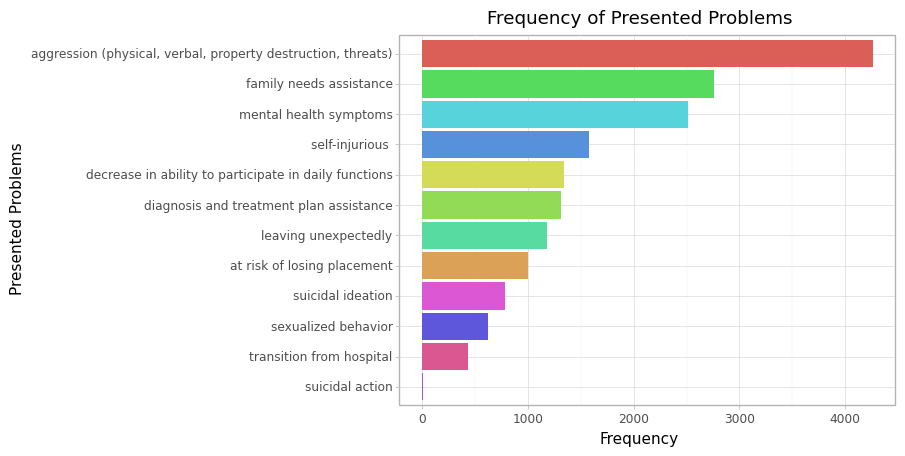

<ggplot: (8779862833038)>

In [32]:
presenting_problems_count_df = pd.DataFrame(demographics_problems_merged.presented_problems.value_counts()).reset_index().rename(
    columns={'index' : 'problem', 'presented_problems' : 'frequency'})
make_custom_bar_plot(df = presenting_problems_count_df, bar_x = 'reorder(problem, frequency)', bar_y = 'frequency', fill_by ='problem', 
                     x_label = 'Presented Problems', y_label = 'Frequency', title='Frequency of Presented Problems', file_name = 'presenting_problems_count.png')

/Users/aimen/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/aimen/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../output/figures/living_condition_at_enrollment.png


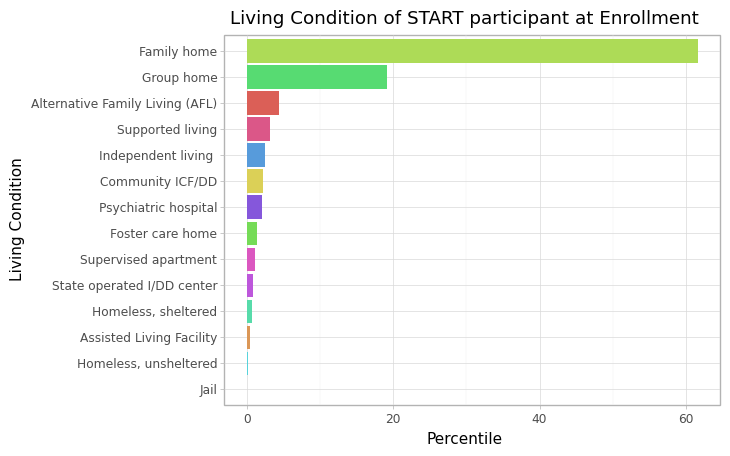

<ggplot: (8779897553032)>

In [33]:
living_condition_no_other = demographics_problems_merged[~demographics_problems_merged['Current living situation at enrollment to START'].str.contains('Other:')].copy()

living_condition_df = pd.DataFrame(living_condition_no_other['Current living situation at enrollment to START'].value_counts()).reset_index().rename(
    columns={'index' : 'living_condition', 'Current living situation at enrollment to START' : 'frequency'})
living_condition_df['frequency_percentile'] = (living_condition_df['frequency']/living_condition_df['frequency'].sum())*100

make_custom_bar_plot(df = living_condition_df, bar_x = 'reorder(living_condition, frequency_percentile)', bar_y = 'frequency_percentile', fill_by = 'living_condition', 
                     x_label = 'Living Condition', y_label = 'Percentile', title='Living Condition of START participant at Enrollment', 
                     file_name = 'living_condition_at_enrollment.png')

/Users/aimen/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/aimen/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../output/figures/presenting_problems_count.png


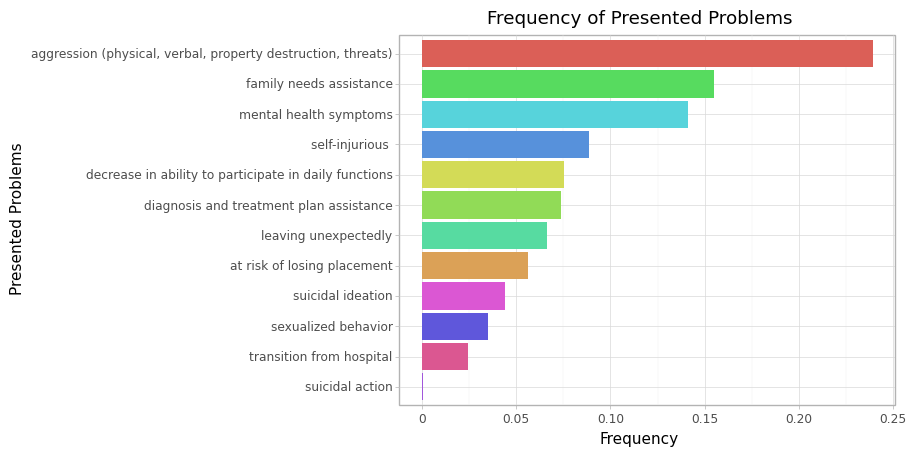

<ggplot: (8779847097597)>

In [35]:
presenting_problems_count_df = pd.DataFrame(demographics_problems_merged.presented_problems.value_counts(normalize=True)).reset_index().rename(
    columns={'index' : 'problem', 'presented_problems' : 'frequency'})
make_custom_bar_plot(df = presenting_problems_count_df, bar_x = 'reorder(problem, frequency)', bar_y = 'frequency', fill_by ='problem', 
                     x_label = 'Presented Problems', y_label = 'Frequency', title='Frequency of Presented Problems', file_name = 'presenting_problems_count.png')

In [41]:
demographics_problems_merged.presented_problems.value_counts(normalize=True)

aggression (physical, verbal, property destruction, threats)    0.239331
family needs assistance                                         0.154818
mental health symptoms                                          0.141229
self-injurious                                                  0.088387
decrease in ability to participate in daily functions           0.075472
diagnosis and treatment plan assistance                         0.074012
leaving unexpectedly                                            0.066094
at risk of losing placement                                     0.056098
suicidal ideation                                               0.044194
sexualized behavior                                             0.035265
transition from hospital                                        0.024371
suicidal action                                                 0.000730
Name: presented_problems, dtype: float64

In [40]:
4262 / 17200

0.2477906976744186